In [1]:
from google.colab import drive

drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [2]:
import os
import pandas as pd

# Download dataset
import kagglehub
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Path to dataset files:", path)

# Set correct paths for CSV files
train_label = f"{path}/Train.csv"
test_label = f"{path}/Test.csv"

# Load CSVs
train_df = pd.read_csv(train_label)
test_df = pd.read_csv(test_label)

# Set paths for Train and Test folders
train_folder = f"{path}"
test_folder = f"{path}"

# Verify paths for Train
train_image_paths = train_df['Path'].apply(lambda x: os.path.join(train_folder, x))
missing_train_images = [path for path in train_image_paths if not os.path.exists(path)]

# Verify paths for Test
test_image_paths = test_df['Path'].apply(lambda x: os.path.join(test_folder, x))
missing_test_images = [path for path in test_image_paths if not os.path.exists(path)]

print("Missing train images:", len(missing_train_images))
print("Missing test images:", len(missing_test_images))

# Verify Train Subfolders
train_subfolders = os.listdir(train_folder + "/Train")
print("Subfolders in Train:", train_subfolders)


# Check contents of a specific class folder (e.g., '0')
if '0' in train_subfolders:
    class_0_files = os.listdir(os.path.join(train_folder + "/Train", '0'))
    print(f"Images in class '0': {class_0_files[:5]}")  # Show first 5 images
else:
    print("Class folder '0' is missing!")


100%|██████████| 612M/612M [00:28<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1
Missing train images: 0
Missing test images: 0
Subfolders in Train: ['25', '9', '36', '16', '37', '12', '27', '11', '30', '22', '32', '21', '20', '13', '14', '2', '6', '5', '10', '42', '41', '28', '29', '34', '8', '3', '7', '40', '4', '18', '26', '19', '1', '23', '33', '35', '24', '39', '31', '15', '17', '0', '38']
Images in class '0': ['00000_00003_00003.png', '00000_00003_00022.png', '00000_00000_00000.png', '00000_00004_00017.png', '00000_00004_00004.png']


In [3]:
import cv2
import matplotlib.pyplot as plt

def draw_bounding_box(image_path, box_coords, box_color=(255, 0, 0), thickness=2):
    """
    Reads an image, draws a bounding box, and displays before and after images using Matplotlib.

    Args:
        image_path (str): Path to the image file.
        box_coords (tuple): Coordinates for the bounding box (x_min, y_min, x_max, y_max).
        box_color (tuple): Color of the bounding box in BGR format (default is blue).
        thickness (int): Thickness of the bounding box (default is 2).
    """
    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found. Please check the path.")

    # Create a copy of the original image for modification
    image_with_box = image.copy()

    # Draw the bounding box
    x_min, y_min, x_max, y_max = box_coords
    cv2.rectangle(image_with_box, (x_min, y_min), (x_max, y_max), box_color, thickness)

    # Convert images from BGR to RGB for Matplotlib
    original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    modified_rgb = cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB)

    # Display original and modified images using Matplotlib
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title("Original Image")
    plt.axis("off")

    # Image with bounding box
    plt.subplot(1, 2, 2)
    plt.imshow(modified_rgb)
    plt.title("Image with Bounding Box")
    plt.axis("off")

    plt.show()

In [4]:
# !cp -r /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1 /content/gtsrb-german-traffic-sign

In [5]:
!pip install ultralytics  # YOLOv8 library
!pip install torch torchvision torchaudio  # PyTorch
!pip install matplotlib  # For plotting images
!pip install opencv-python-headless  # OpenCV for image processing (use headless for Colab)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.4/898.4 kB 47.0 MB/s eta 0:00:00


In [6]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from pathlib import Path


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
def convert_annotation(row, img_width, img_height):
    # Extract bounding box coordinates from the CSV row
    x_min = row['Roi.X1']
    y_min = row['Roi.Y1']
    x_max = row['Roi.X2']
    y_max = row['Roi.Y2']

    # Calculate YOLO format (normalized coordinates)
    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height

    # ClassId from the CSV as the label
    label = row['ClassId']

    # Return YOLO formatted annotation as a string
    return f"{label} {x_center} {y_center} {width} {height}"


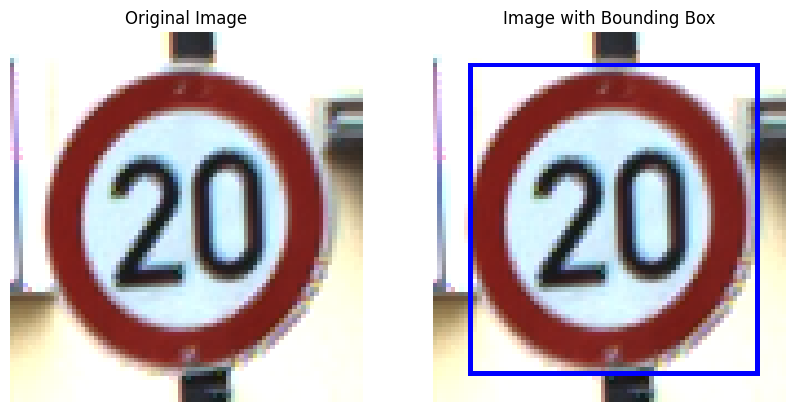

In [8]:
idx = 500
draw_bounding_box(
    f"{path}/{train_df['Path'][idx]}",
     (
         train_df['Roi.X1'][idx],
         train_df['Roi.Y1'][idx],
         train_df['Roi.X2'][idx],
         train_df['Roi.Y2'][idx],
     ),
    thickness=1
 )

In [9]:
try:
  shutil.rmtree(f"{path}/images")
except:
  pass

try:
  shutil.rmtree(f"{path}/labels")
except:
  pass

In [10]:
import os
import pandas as pd

# Load the train CSV file
train_df = pd.read_csv(f"{path}/Train.csv")

# Path to the Train folder (where your images are stored)
train_folder = f"{path}"

# Try to make labels dir, if already exists ignore
try:
  os.mkdir(f"{path}/labels")
except:
  pass

# Try to make labels/train dir, if already exists ignore
try:
  os.mkdir(f"{path}/labels/train")
except:
  pass
save_text_files = f"{path}/labels/train"
# Loop through each row in the train CSV to convert annotations
for idx, row in train_df.iterrows():
    # Get the image file path
    img_path = os.path.join(train_folder, row['Path'])
    img_name = os.path.basename(img_path).replace(".png", ".txt")  # Change file extension to .txt

    # Get the image width and height
    img_width = row['Width']
    img_height = row['Height']

    # Convert annotation to YOLO format
    annotation = convert_annotation(row, img_width, img_height)

    # Save YOLO annotations in a text file with the same name as the image
    txt_path = os.path.join(save_text_files, img_name)
    with open(txt_path, 'w') as f:
        f.write(annotation)


In [11]:
try:
  os.mkdir(f"{path}/images")
except:
  pass

try:
  os.mkdir(f"{path}/labels")
except:
  pass

In [12]:
try:
  os.mkdir(f"{path}/images/train")
except:
  pass

try:
  os.mkdir(f"{path}/labels/train")
except:
  pass

In [13]:
import os
import shutil

def copy_contents_to_existing_folder(source_folder, destination_folder):
    """
    Copies all contents (files and subfolders) from a source folder to an existing destination folder.

    Args:
        source_folder (str): Path to the source folder.
        destination_folder (str): Path to the destination folder.
    """
    if not os.path.exists(source_folder):
        print(f"Source folder '{source_folder}' does not exist.")
        return

    if not os.path.exists(destination_folder):
        print(f"Destination folder '{destination_folder}' does not exist.")
        return

    for item in os.listdir(source_folder):
        source_path = os.path.join(source_folder, item)
        destination_path = os.path.join(destination_folder, item)

        try:
            # If it's a directory, copy recursively
            if os.path.isdir(source_path):
                if os.path.exists(destination_path):
                    print(f"Directory '{destination_path}' already exists, merging contents.")
                shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
            # If it's a file, copy directly
            else:
                shutil.copy2(source_path, destination_path)
            # print(f"Copied: {source_path} -> {destination_path}")
        except Exception as e:
            print(f"Error copying {source_path} to {destination_path}: {e}")

In [14]:
for dir in os.listdir(f"{path}/Train"):
  if os.path.isdir(os.path.join(f"{path}/Train", dir)):
    copy_contents_to_existing_folder(os.path.join(f"{path}/Train", dir), os.path.join(f"{path}/images/train"))


In [15]:
import random
# copy random data from images/train and respective labels from labels/train to images/val and images/label
copy_n = 300
images = os.listdir(f"{path}/images/train")

random_numbers = random.sample(range(len(images)), copy_n)

try:
  shutil.rmtree(f"{path}/images/val")
except Exception as e:
  print(e)
os.mkdir(f"{path}/images/val")

try:
  shutil.rmtree(f"{path}/labels/val")
except Exception as e:
  print(e)

os.mkdir(f"{path}/labels/val")

copied = 0
for idx in random_numbers:
  if os.path.exists(f"{path}/images/train/{images[idx]}") and os.path.exists(f"{path}/labels/train/{images[idx].replace('png','txt')}"):
    shutil.copy(f"{path}/images/train/{images[idx]}", f"{path}/images/val/{images[idx]}")
    shutil.copy(f"{path}/labels/train/{images[idx].replace('png', 'txt')}", f"{path}/labels/val/{images[idx].replace('png', 'txt')}")
    copied += 1

print(f"Total copied: {copied}/{copy_n}")



[Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/images/val'
[Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/labels/val'
Total copied: 300/300


In [16]:
print(len(os.listdir(f"{path}/images/val")))
print(len(os.listdir(f"{path}/labels/val")))

300
300


In [17]:
!dir /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/images/train | head -n 5

00000_00000_00000.png  00005_00057_00023.png  00012_00053_00016.png  00025_00031_00009.png
00000_00000_00001.png  00005_00057_00024.png  00012_00053_00017.png  00025_00031_00010.png
00000_00000_00002.png  00005_00057_00025.png  00012_00053_00018.png  00025_00031_00011.png
00000_00000_00003.png  00005_00057_00026.png  00012_00053_00019.png  00025_00031_00012.png
00000_00000_00004.png  00005_00057_00027.png  00012_00053_00020.png  00025_00031_00013.png


In [18]:
model = YOLO("yolov8m.pt")
# model = YOLO("/content/checkpoints/checkpoint_epoch_0.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 242MB/s]


In [19]:
with open("data.yaml", "w") as f:
  f.writelines("""
train: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/images/train  # train images (relative to 'path') 128 images
val: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/images/val # val images (relative to 'path') 128 images
# test:  # test images (optional)
# Classes
nc: 43  # number of classes
names: ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)','Speed limit (70km/h)','Speed limit (80km/h)','End Maximum Speed Limit (80km/h)','Speed limit (100km/h)','Speed limit (120km/h)',
'No Overtaking','No Overtaking by Trucks','Road continues to the right','Slow down and be prepare to stop','Yield Sign','Stop Sign','No Stopping','Trucks not allowed','No Entry',
'Danger','Left bend is approaching','Right bend is approaching','Slow down for upcoming turns','Uneven Road surface ahead','Slippery Road','Narrow road ahead', 'Road work ahead',
'Traffic Signals ahead','Pedestrian crossing ahead','Pedestrian (children) crossing ahead','Cyclists crossing Sign','No vehicles approaching on secondary road', 'Wild animals (deer) crossing road','End of all speed bans',
'Turn Right', 'Turn left','Go straight','Go straight or turn right','Go straight or turn left','Keep right','Keep left','Roundabout Sign','End of no overtaking zone','End of no overtaking truck zone'
]
""")

In [ ]:
model.train(
      data='/content/data.yaml',  
      epochs=11,
      name='/content/MyDrive/MyDrive/experiment', #this argument directly store the results in drive,so if run time of gpu get disconntect, we dont loose the training results.
      project='project'
)

Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/data.yaml, epochs=11, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=project, name=experiment2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

100%|██████████| 5.35M/5.35M [00:00<00:00, 327MB/s]


AMP: checks passed ✅


train: Scanning /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/labels/train... 39209 images, 0 backgrounds, 0 corrupt: 100%|██████████| 39209/39209 [00:22<00:00, 1724.49it/s]


train: New cache created: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/labels/val... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 951.18it/s]

val: New cache created: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/labels/val.cache


Plotting labels to /content/MyDrive/MyDrive/experiment2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000213, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/MyDrive/MyDrive/experiment2
Starting training for 11 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/11      6.92G     0.6464      1.481      1.203         22        640: 100%|██████████| 2451/2451 [22:43<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]

                   all        300        300      0.811      0.936      0.945      0.863


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/11      6.94G     0.5201     0.4073      1.229          9        640: 100%|██████████| 2451/2451 [22:19<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


                   all        300        300      0.824      0.972      0.959      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/11      6.93G     0.4922     0.3431        1.2          9        640: 100%|██████████| 2451/2451 [22:02<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]

                   all        300        300      0.941      0.929      0.961      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/11      6.92G     0.4646     0.2989      1.171          9        640: 100%|██████████| 2451/2451 [21:59<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


                   all        300        300      0.928       0.92      0.963      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/11      6.97G     0.4373     0.2658      1.144          9        640: 100%|██████████| 2451/2451 [21:58<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


                   all        300        300      0.967      0.952      0.986       0.96

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/11      6.84G     0.4208     0.2397      1.131          9        640: 100%|██████████| 2451/2451 [21:57<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


                   all        300        300      0.967      0.969      0.994      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/11      6.93G      0.403     0.2144      1.119          9        640: 100%|██████████| 2451/2451 [21:58<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


                   all        300        300      0.976      0.992      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/11      6.93G     0.3879     0.1978      1.107          9        640: 100%|██████████| 2451/2451 [22:00<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


                   all        300        300      0.984          1      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/11      6.96G     0.3781      0.181        1.1          9        640: 100%|██████████| 2451/2451 [22:00<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        300        300      0.981      0.978      0.992      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/11      6.83G     0.3645      0.168      1.088          9        640: 100%|██████████| 2451/2451 [22:01<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        300        300      0.989      0.999      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/11      6.94G     0.3534     0.1556      1.078          9        640: 100%|██████████| 2451/2451 [21:58<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

                   all        300        300      0.991          1      0.995      0.979



11 epochs completed in 4.074 hours.
Optimizer stripped from /content/MyDrive/MyDrive/experiment2/weights/last.pt, 52.1MB
Optimizer stripped from /content/MyDrive/MyDrive/experiment2/weights/best.pt, 52.1MB

Validating /content/MyDrive/MyDrive/experiment2/weights/best.pt...
Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,864,657 parameters, 0 gradients, 78.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


                   all        300        300      0.991          1      0.995      0.979
  Speed limit (20km/h)          6          6      0.982          1      0.995      0.995
  Speed limit (30km/h)         13         13          1      0.989      0.995      0.972
  Speed limit (50km/h)         19         19          1          1      0.995      0.963
  Speed limit (60km/h)         12         12          1          1      0.995      0.984
  Speed limit (70km/h)         12         12      0.994          1      0.995      0.976
  Speed limit (80km/h)         17         17      0.994          1      0.995      0.962
End Maximum Speed Limit (80km/h)          6          6          1          1      0.995      0.961
 Speed limit (100km/h)          8          8          1          1      0.995      0.995
 Speed limit (120km/h)          8          8          1          1      0.995      0.995
         No Overtaking         14         14      0.992          1      0.995      0.988
No Overtaki

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7872be6e48e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036

In [ ]:
"runs/detect/train"

'runs/detect/train'

In [ ]:
# # Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# # Step 2: Copy the model directory to Google Drive
# !cp -r runs/detect/train /content/drive/My\ Drive/model_runs/train

Mounted at /content/drive
